In [1]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tslearn.clustering import TimeSeriesKMeans
from sklearn.model_selection import train_test_split
import seaborn as sns
import utils
from importlib import reload
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from datetime import datetime



2023-09-16 13:49:28.463088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 13:49:32.040364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fcc0ed941f0>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, 

In [2]:
print("HELLOAS")
feature_list = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6',
                'PctChgVol','sumPctChgVol_2','sumPctChgVol_3','sumPctChgVol_4','sumPctChgVol_5','sumPctChgVol_6',
                'PctChgVix','sumPctChgVix_2','sumPctChgVix_3','sumPctChgVix_4','sumPctChgVix_5','sumPctChgVix_6','Close','Volume']
# feature_list = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6','Close']
n_steps = 15

features = len(feature_list)
run_name = datetime.today().strftime('%Y-%m-%d_%H-%M')
run_number = 0
tstart = 2015
tend = 2020

# tickerList = ['aapl','spy','amd','qqq','amzn','meta','msft','f']
# tickerList = ['aapl','spy','amd','qqq']
tickerList = ['aapl']

trend_features = ['Close','Volume']
pctChg_features = [f for f in feature_list if f not in trend_features]
# cluster_features = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6']
cluster_features = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3']

predictive_features = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6']

remaining_features = [f for f in feature_list if f not in predictive_features and f not in trend_features]

print("HELLOAS")



HELLOAS
HELLOAS


In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_abs_trimmed_ = None
    
    def fit(self, X, y=None):
        # Assuming X is a DataFrame
        low, high = np.percentile(X, [5, 95], axis=0)  # axis=0 computes percentiles column-wise
        self.max_abs_trimmed_ = np.maximum(np.abs(low), np.abs(high))
        return self

    def transform(self, X):
        # Clip data column-wise
        X = np.clip(X, -self.max_abs_trimmed_, self.max_abs_trimmed_)

        # Scale values between -1 and 1 for each column, maintaining zero
        pos_mask = X > 0
        neg_mask = X < 0
        
        X[pos_mask] = X[pos_mask] / self.max_abs_trimmed_
        X[neg_mask] = X[neg_mask] / self.max_abs_trimmed_

        return X
    
    def inverse_transform(self, X):
        # Ensure we're working with a numpy array
        if isinstance(X, pd.DataFrame):
            X = X.values  # Convert to NumPy array

        X = X * self.max_abs_trimmed_

        return X


In [21]:
run_path = "ClusterRuns/"+run_name+"/"+str(run_number)

if not os.path.exists(run_path):
    os.makedirs(run_path)

# Construct file name
file_name = os.path.join(run_path, "results.txt")

# Create and open the run_number.txt file for writing

run_info = ""
run_info += "Tickers: " + str(tickerList) + "\n"
run_info += "cluster_features: " + str(cluster_features) + "\n"
run_info += "n_steps: " + str(n_steps)+ "\n"
run_info += "Start: " + str(tstart) + " end: " + str(tend) + "\n\n"

with open(file_name, 'w') as file:
    file.write(run_info)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


array([ 0.04277316, -0.69277796, -0.59224456, -0.58833706, -1.        ,
       -0.92827751])

(1491, 6)

array([-5.58456018e-01, -3.47484733e-01, -3.24260367e-01, -3.62935577e-01,
       -4.15074674e-01, -3.68113334e-01,  4.58448153e-01,  2.66693058e-01,
        1.39397104e-01,  8.05286943e-02,  1.30219136e-01,  8.43625725e-02,
        2.72834295e-03, -1.48328248e-01, -2.14151317e-01,  3.53734309e-02,
        5.53856847e-02,  4.28733796e-02,  1.33190002e+02,  8.05763000e+07])

(645, 6)

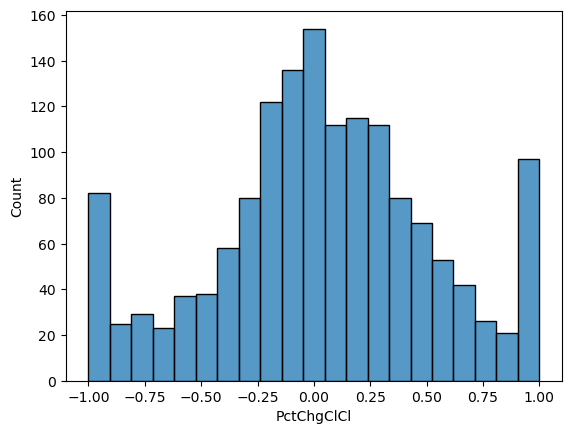

In [22]:

reload(utils)
combined_train_df = pd.DataFrame()
combined_test_df = pd.DataFrame()
all_train = [] 
all_test = []

for ticker in tickerList:
    df = utils.prepareStockDf(ticker,tstart)
    training_set, test_set = utils.train_test_split(df,tstart, tend, feature_list)
    test_set = test_set.iloc[n_steps:,:] # Remove the first n_steps rows from the test set
    combined_train_df = pd.concat([combined_train_df,training_set],axis=0)
    combined_test_df = pd.concat([combined_test_df,test_set],axis=0)
    all_train.append(training_set)
    all_test.append(test_set)

predictiveScaler = CustomScaler()
remainingScaler = CustomScaler() 

predictiveScaler.fit(combined_train_df[predictive_features])
# combined_train_df[predictive_features] = predictiveScaler.transform(combined_train_df[predictive_features])
# combined_test_df[predictive_features] = predictiveScaler.transform(combined_test_df[predictive_features])

remainingScaler.fit(combined_train_df[remaining_features])
# combined_train_df[remaining_features] = remainingScaler.transform(combined_train_df[remaining_features])
# combined_test_df[remaining_features] = remainingScaler.transform(combined_test_df[remaining_features])



# Initialize arrays as empty arrays with the necessary number of dimensions
X_train, X_test = np.empty((0, n_steps, len(feature_list))), np.empty((0, n_steps, len(feature_list)))
y_train, y_test = np.empty((0, 6)), np.empty((0, 6))

for i,val in enumerate(all_train): 
    
    training_set = all_train[i]
    test_set = all_test[i]

    training_set[predictive_features] = predictiveScaler.transform(training_set[predictive_features])
    training_set[remaining_features] = remainingScaler.transform(training_set[remaining_features])

    test_set[predictive_features] = predictiveScaler.transform(test_set[predictive_features])
    test_set[remaining_features] = remainingScaler.transform(test_set[remaining_features])
    
    sns.histplot(training_set['PctChgClCl'])
    cur_X_train, cur_y_train = utils.split_sequence(training_set.values, n_steps)
    cur_X_test, cur_y_test = utils.split_sequence(test_set.values, n_steps)

    # Append cur_X_train, cur_X_test, cur_y_train, cur_y_test to the total arrays
    X_train = np.concatenate((X_train, cur_X_train), axis=0)
    X_test = np.concatenate((X_test, cur_X_test), axis=0)
    y_train = np.concatenate((y_train, cur_y_train), axis=0)
    y_test = np.concatenate((y_test, cur_y_test), axis=0)





display(y_test[2])
display(y_train.shape)
display(X_test[0,-1,:])
display(y_test.shape)


In [23]:

trend_feature_index = [feature_list.index(trend) for trend in trend_features]

X_train = utils.scale_patterns(X_train,trend_feature_index)
display(X_train[0:1,:,-1])

array([[0.34104626, 0.62955576, 0.66891276, 0.        , 0.50142941,
        0.35393179, 0.24851721, 0.70262501, 0.23044257, 0.51834022,
        1.        , 0.25500294, 0.22053042, 0.35645475, 0.16556445]])

In [24]:
cluster_feature_index = [feature_list.index(cluster_feature) for cluster_feature in cluster_features]
X_cluster = utils.create_Cluster_Seq(X_train,cluster_feature_index)
display(X_cluster.shape)
display(X_cluster[0:1,:,-1])


(1491, 15, 3)

array([[-0.81291229, -1.        , -0.75016794, -0.2804952 ,  1.        ,
         1.        ,  0.29643689, -0.29315085, -0.3905998 , -0.44048343,
        -0.77273695, -0.18266656,  0.51131507,  1.        ,  0.77451392]])

In [25]:
import math
n_clusters = math.ceil(math.sqrt(len(X_cluster))) // 3
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=n_clusters)

labels = km.fit_predict(X_cluster)

In [26]:
reload(utils)
threshold_factor = .5 # Adjust as necessary

X_cluster_adj, X_train_adj, y_train_adj, labels_adj = utils.remove_outliers(X_cluster,X_train,y_train,labels,km,threshold_factor)
display(X_cluster.shape)
display(X_train.shape)
display(y_train.shape)
display(X_cluster_adj.shape)
display(X_train_adj.shape)
display(y_train_adj.shape)
display(labels_adj.shape)

(1491, 15, 3)

(1491, 15, 20)

(1491, 6)

(1052, 15, 3)

(1052, 15, 20)

(1052, 6)

(1052,)

In [27]:
reload(utils)
utils.visualizeData(labels_adj,X_cluster_adj)


In [28]:
# cluster_assignments = km.predict(X_test)
# set(cluster_assignments)

In [29]:
import pickle 
visualDict = {'labels': labels_adj, 'X_train':X_cluster_adj}
pickle_name = os.path.join(run_path, "X_train.pkl")

with open(pickle_name, 'wb') as file:
    pickle.dump(visualDict,file)

In [30]:
if len(y_train.shape) == 1:
    df = pd.DataFrame({'label': labels_adj, 'target': y_train_adj})
else:
    # Convert the 2D y_train into a DataFrame
    y_df = pd.DataFrame(y_train_adj, columns=[f'target_{i}' for i in range(y_train_adj.shape[1])])
    df = pd.concat([pd.DataFrame({'label': labels_adj}), y_df], axis=1)

df.head()
display(df['label'].value_counts())


12    112
3     106
8      98
2      95
11     92
0      89
7      86
1      74
5      74
6      65
9      62
10     52
4      47
Name: label, dtype: int64

In [31]:
# display(X_train.shape)
# display(y_train.mean())
# display(cluster_X_train[0])

# label_filter = 1
# filtered_x_train, filtered_y_train = utils.filter_clusters(labels,label_filter,X_train_scaled,y_train_scaled)
# filtered_x_train.shape

In [33]:
def create_model():
    model_lstm = Sequential()

    # Using Bidirectional LSTM for the first layer
    model_lstm.add(Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True), input_shape=(None, features)))
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=100, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    # model_lstm.add(GRU(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    # model_lstm.add(BatchNormalization())  # Batch normalization
    # model_lstm.add(Dropout(0.2))

    # model_lstm.add(GRU(units=100, activation='tanh', return_sequences=True))  # Changed number of units to 250
    # model_lstm.add(BatchNormalization())  # Batch normalization
    # model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=100, activation='tanh'))  # Changed number of units to 100
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(Dense(units=6))

    # Using Adam optimizer with a learning rate scheduler
    optimizer = Adam(learning_rate=0.001)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-5)

    model_lstm.compile(optimizer=optimizer, loss="mse")
    return model_lstm







In [34]:
reload(utils)

<module 'utils' from '/home/ajp031/StockDeepLearning/StockDeepLearning/utils.py'>

In [35]:
for lab in set(labels_adj): 
    filtered_x_train, filtered_y_train = utils.filter_clusters(labels_adj, lab, X_train_adj, y_train_adj)

    X_test = utils.scale_patterns(X_test,trend_feature_index)
    # display(X_train[0:1,:,-1])
    X_cluster_test = utils.create_Cluster_Seq(X_test,cluster_feature_index)
    # display(X_cluster_test.shape)

    cluster_assignments = km.predict(X_cluster_test)

    # values, counts = np.unique(cluster_assignments, return_counts=True)

    # # Display the results
    # for value, count in zip(values, counts):
    #     print(f"Value: {value}, Count: {count}")

    X_cluster_test_adj,X_test_adj, y_test_adj, labels_test_adj = utils.remove_outliers(X_cluster_test,X_test,y_test,cluster_assignments,km,threshold_factor)

    filtered_x_test, filtered_y_test = utils.filter_clusters(labels_test_adj, lab, X_test_adj, y_test_adj)
    
    # display(X_cluster_test_adj.shape)
    # display(filtered_x_test.shape)
    # display(filtered_y_test.shape)

    if len(filtered_x_test) == 0:
        continue

    # display(filtered_x_train.shape)
    model_lstm = create_model()
    model_lstm.fit(filtered_x_train, filtered_y_train, batch_size=30, epochs=5, verbose=1)

    

    predicted_stock_price = model_lstm.predict(filtered_x_test)

    print(predictiveScaler.max_abs_trimmed_.shape)

    print(predicted_stock_price.shape)



    predicted_stock_price = predictiveScaler.inverse_transform(predicted_stock_price)
    filtered_y_test = predictiveScaler.inverse_transform(filtered_y_test)

    # Assuming predicted_stock_price has two columns
    results = pd.DataFrame({
        'predicted_1': predicted_stock_price[:, 0],
        'predicted_2': predicted_stock_price[:, 1],
        'predicted_3': predicted_stock_price[:, 2],
        'predicted_4': predicted_stock_price[:, 3],
        'predicted_5': predicted_stock_price[:, 4],
        'predicted_6': predicted_stock_price[:, 5],
        'real_1': filtered_y_test[:, 0],
        'real_2': filtered_y_test[:, 1],
        'real_3': filtered_y_test[:, 2],
        'real_4': filtered_y_test[:, 3],
        'real_5': filtered_y_test[:, 4],
        'real_6': filtered_y_test[:, 5]
    })

    # Assuming a correct prediction means both predicted features have the same sign as their corresponding real values
    results['same_1'] = ((results['predicted_1'] > 0) & (results['real_1'] > 0)) | ((results['predicted_1'] < 0) & (results['real_1'] < 0))
    results['same_2'] = ((results['predicted_2'] > 0) & (results['real_2'] > 0)) | ((results['predicted_2'] < 0) & (results['real_2'] < 0))
    results['same_3'] = ((results['predicted_3'] > 0) & (results['real_3'] > 0)) | ((results['predicted_3'] < 0) & (results['real_3'] < 0))
    results['same_4'] = ((results['predicted_4'] > 0) & (results['real_4'] > 0)) | ((results['predicted_4'] < 0) & (results['real_4'] < 0))
    results['same_5'] = ((results['predicted_5'] > 0) & (results['real_5'] > 0)) | ((results['predicted_5'] < 0) & (results['real_5'] < 0))
    results['same_6'] = ((results['predicted_6'] > 0) & (results['real_6'] > 0)) | ((results['predicted_6'] < 0) & (results['real_6'] < 0))
    accuracy1 = results['same_1'].sum() / len(results) * 100
    accuracy2 = results['same_2'].sum() / len(results) * 100
    accuracy3 = results['same_3'].sum() / len(results) * 100
    accuracy4 = results['same_4'].sum() / len(results) * 100
    accuracy5 = results['same_5'].sum() / len(results) * 100
    accuracy6 = results['same_6'].sum() / len(results) * 100

    # Construct the string
    output_string = (
        "Cluster Number: " + str(lab) +
        " \nAccuracy1D " + str(accuracy1) + " PredictedRet: " + str(results['predicted_1'].mean()) + " ActRet " + str(results['real_1'].mean() ) +
        " \nAccuracy2D " + str(accuracy2) + " PredictedRet: " + str(results['predicted_2'].mean()) + " ActRet " + str(results['real_2'].mean() ) +
        " \nAccuracy3D " + str(accuracy3) + " PredictedRet: " + str(results['predicted_3'].mean()) + " ActRet " + str(results['real_3'].mean() ) +
        " \nAccuracy4D " + str(accuracy4) + " PredictedRet: " + str(results['predicted_4'].mean()) + " ActRet " + str(results['real_4'].mean() ) +
        " \nAccuracy5D " + str(accuracy5) + " PredictedRet: " + str(results['predicted_5'].mean()) + " ActRet " + str(results['real_5'].mean() ) +
        " \nAccuracy6D " + str(accuracy6) + " PredictedRet: " + str(results['predicted_6'].mean()) + " ActRet " + str(results['real_6'].mean() ) +
        " Test set length: " + str(len(filtered_y_test)) + "\n"
    )

    # Write the string to a file
    with open(file_name, 'a') as f:
        f.write(output_string)






2023-09-16 14:52:02.962753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:02.966278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:02.968595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:52:05.163526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:05.166791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:05.169391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 17s 91ms/step - loss: 2.3656
Epoch 2/5
3/3 [==============================] - 0s 99ms/step - loss: 1.4609
Epoch 3/5
3/3 [==============================] - 0s 87ms/step - loss: 1.1660
Epoch 4/5
3/3 [==============================] - 0s 93ms/step - loss: 1.0369
Epoch 5/5
3/3 [==============================] - 0s 95ms/step - loss: 0.9940


2023-09-16 14:52:23.874150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:23.875683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:23.877268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 3s 15ms/step
(6,)
(39, 6)


2023-09-16 14:52:27.291212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:27.292628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:27.294222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:52:28.698463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:28.700485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:28.703198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 13s 61ms/step - loss: 2.5593
Epoch 2/5
3/3 [==============================] - 0s 66ms/step - loss: 1.9048
Epoch 3/5
3/3 [==============================] - 0s 60ms/step - loss: 1.1984
Epoch 4/5
3/3 [==============================] - 0s 63ms/step - loss: 1.0863
Epoch 5/5
3/3 [==============================] - 0s 61ms/step - loss: 1.0191


2023-09-16 14:52:42.859001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:42.860552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:42.862237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 16ms/step
(6,)
(36, 6)


2023-09-16 14:52:45.688409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:45.690858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:45.694696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:52:46.944079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:52:46.945544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:52:46.947194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 14s 65ms/step - loss: 2.0390
Epoch 2/5
4/4 [==============================] - 0s 82ms/step - loss: 1.3962
Epoch 3/5
4/4 [==============================] - 0s 63ms/step - loss: 1.1380
Epoch 4/5
4/4 [==============================] - 0s 65ms/step - loss: 0.9605
Epoch 5/5
4/4 [==============================] - 0s 60ms/step - loss: 0.8907


2023-09-16 14:53:02.298949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:02.300713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:02.302185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 17ms/step
(6,)
(45, 6)


2023-09-16 14:53:05.082959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:05.085016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:05.087040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:53:06.897482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:06.899484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:06.902126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 15s 75ms/step - loss: 2.3656
Epoch 2/5
4/4 [==============================] - 0s 76ms/step - loss: 1.4509
Epoch 3/5
4/4 [==============================] - 0s 95ms/step - loss: 1.1111
Epoch 4/5
4/4 [==============================] - 0s 94ms/step - loss: 0.9273
Epoch 5/5
4/4 [==============================] - 0s 95ms/step - loss: 0.7989


2023-09-16 14:53:23.160256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:23.163085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:23.165356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 4s 24ms/step
(6,)
(42, 6)


2023-09-16 14:53:27.354150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:27.357812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:27.361552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:53:29.351169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:29.353795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:29.356241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 20s 102ms/step - loss: 2.1640
Epoch 2/5
2/2 [==============================] - 0s 83ms/step - loss: 1.5073
Epoch 3/5
2/2 [==============================] - 0s 110ms/step - loss: 1.3699
Epoch 4/5
2/2 [==============================] - 0s 91ms/step - loss: 1.0700
Epoch 5/5
2/2 [==============================] - 0s 95ms/step - loss: 1.3101


2023-09-16 14:53:50.816870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:50.820370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:50.824085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step
(6,)
(29, 6)


2023-09-16 14:53:55.014356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:55.016375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:55.017912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:53:57.649244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:53:57.653055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:53:57.656561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 22s 117ms/step - loss: 2.6368
Epoch 2/5
3/3 [==============================] - 0s 105ms/step - loss: 1.6789
Epoch 3/5
3/3 [==============================] - 0s 103ms/step - loss: 1.1916
Epoch 4/5
3/3 [==============================] - 0s 113ms/step - loss: 0.9979
Epoch 5/5
3/3 [==============================] - 0s 118ms/step - loss: 0.9617


2023-09-16 14:54:21.493900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:54:21.497798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:54:21.500727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step
(6,)
(29, 6)


2023-09-16 14:54:25.713575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:54:25.717260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:54:25.720809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:54:28.324577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:54:28.328489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:54:28.332794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 19s 104ms/step - loss: 2.1618
Epoch 2/5
3/3 [==============================] - 0s 105ms/step - loss: 1.8547
Epoch 3/5
3/3 [==============================] - 0s 107ms/step - loss: 1.3434
Epoch 4/5
3/3 [==============================] - 0s 106ms/step - loss: 1.1179
Epoch 5/5
3/3 [==============================] - 0s 100ms/step - loss: 1.0220


2023-09-16 14:54:48.890384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:54:48.894938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:54:48.898167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step
(6,)
(23, 6)


2023-09-16 14:54:55.208269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:54:55.214950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:54:55.222267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:54:56.759822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:54:56.762664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:54:56.765304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 16s 99ms/step - loss: 2.2576
Epoch 2/5
3/3 [==============================] - 0s 92ms/step - loss: 1.5295
Epoch 3/5
3/3 [==============================] - 0s 101ms/step - loss: 1.1228
Epoch 4/5
3/3 [==============================] - 0s 97ms/step - loss: 1.0302
Epoch 5/5
3/3 [==============================] - 0s 97ms/step - loss: 0.9601


2023-09-16 14:55:14.215253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:55:14.218008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:55:14.220513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 3s 26ms/step
(6,)
(35, 6)


2023-09-16 14:55:17.616458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:55:17.619669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:55:17.623382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:55:19.188719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:55:19.191706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:55:19.194226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 21s 103ms/step - loss: 2.0264
Epoch 2/5
4/4 [==============================] - 0s 114ms/step - loss: 1.3479
Epoch 3/5
4/4 [==============================] - 0s 115ms/step - loss: 1.1146
Epoch 4/5
4/4 [==============================] - 0s 106ms/step - loss: 0.9870
Epoch 5/5
4/4 [==============================] - 0s 119ms/step - loss: 0.8586


2023-09-16 14:55:42.407315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:55:42.410322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:55:42.414055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 4s 15ms/step
(6,)
(35, 6)


2023-09-16 14:55:46.421791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:55:46.425764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:55:46.428986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:55:49.013053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:55:49.016935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:55:49.022353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 19s 83ms/step - loss: 2.5116
Epoch 2/5
3/3 [==============================] - 0s 88ms/step - loss: 2.0193
Epoch 3/5
3/3 [==============================] - 0s 81ms/step - loss: 1.3054
Epoch 4/5
3/3 [==============================] - 0s 73ms/step - loss: 1.0924
Epoch 5/5
3/3 [==============================] - 0s 80ms/step - loss: 1.2617


2023-09-16 14:56:09.084150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:56:09.086753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:56:09.088773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 3s 16ms/step
(6,)
(44, 6)


2023-09-16 14:56:12.411142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:56:12.413660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:56:12.415979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:56:14.044493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:56:14.047497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:56:14.049958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 18s 91ms/step - loss: 2.5520
Epoch 2/5
2/2 [==============================] - 0s 82ms/step - loss: 1.7766
Epoch 3/5
2/2 [==============================] - 0s 97ms/step - loss: 1.3180
Epoch 4/5
2/2 [==============================] - 0s 78ms/step - loss: 1.0568
Epoch 5/5
2/2 [==============================] - 0s 73ms/step - loss: 0.9422


2023-09-16 14:56:33.813653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:56:33.815811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:56:33.818182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step
(6,)
(30, 6)


2023-09-16 14:56:37.293358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:56:37.296492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:56:37.298777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:56:39.524710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:56:39.526788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:56:39.528821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 18s 107ms/step - loss: 2.0596
Epoch 2/5
4/4 [==============================] - 0s 92ms/step - loss: 1.7730
Epoch 3/5
4/4 [==============================] - 0s 89ms/step - loss: 1.4777
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 1.2875
Epoch 5/5
4/4 [==============================] - 0s 89ms/step - loss: 1.0362


2023-09-16 14:56:59.032604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:56:59.035332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:56:59.037655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 5s 20ms/step
(6,)
(37, 6)


2023-09-16 14:57:04.612148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:57:04.614795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:57:04.617255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-09-16 14:57:06.911746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:57:06.922905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:57:06.925503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 16s 94ms/step - loss: 2.0884
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 1.3281
Epoch 3/5
4/4 [==============================] - 0s 91ms/step - loss: 1.1483
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.9136
Epoch 5/5
4/4 [==============================] - 0s 89ms/step - loss: 0.8081


2023-09-16 14:57:24.509433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-16 14:57:24.511959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-16 14:57:24.514523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step
(6,)
(30, 6)
